# Generate Data

In [2]:
from matplotlib import pyplot as plt
from sklearn.datasets import make_classification
import seaborn as sns
import numpy as np
import pandas as pd
import random
from sklearn.metrics.pairwise import manhattan_distances


def generate_data():
    return make_classification(n_samples=n_obs, 
                           n_features=5, 
                           n_informative=3, 
                           n_redundant=0, 
                           n_repeated=0, 
                           n_classes=2, 
                           n_clusters_per_class=3, 
                           weights=None, 
                           flip_y=0.05,
                           class_sep=0.5,
                           hypercube=True,
                           shift=0.0,
                           scale=1.0,
                           shuffle=True,
                           random_state=None)

def real_data():
    df = pd.read_csv('creditdefault_train.csv',
                    header=0,
                    nrows=n_obs,
                    skiprows=lambda x: random.random()>0.5 if x>0 else False)
    print(df.columns)
    to_keep = ['LIMIT_BAL', 'AGE',
               'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
               'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
               'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',]
    print('Columns kept:', to_keep)    
    return np.array(df[to_keep].apply(pd.to_numeric)), np.array(df.iloc[:, -1])




'''
NUMBER OF OBSERVATIONS AND FEATURES
'''
n_obs = 500
#n_features = 25

X, y = generate_data()
#X, y = real_data()

'''
SCALE BETWEEN -1; 1
'''
X = (X - X.mean(axis=0))
X = X / list(map(max, zip(abs(X.max(axis=0)), abs(X.min(axis=0)))))


print(y.mean())


0.498


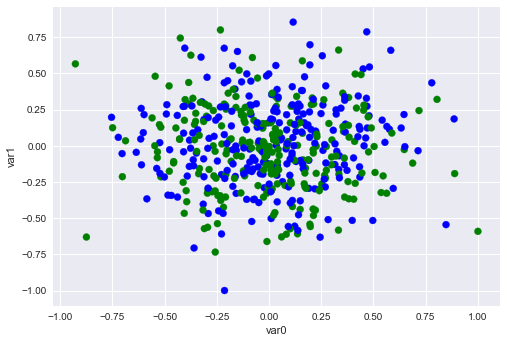

In [3]:
AX1, AX2 = 3, 2

#2D plot
plt.scatter(X[:, AX1], X[:, AX2], color=[['blue', 'green'][int(i)] for i in y])
if 'idx' in globals():
    plt.scatter(X[idx,AX1], X[idx, AX2], color='red')
plt.xlabel('var0')
plt.ylabel('var1')
plt.show()

# Train a Classifier

In [497]:
'''
This script tests implementation of a usage of LIME https://github.com/marcotcr/lime
'''
from __future__ import print_function
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neural_network import MLPClassifier, BernoulliRBM
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import lime
import lime.lime_tabular
import random


X_train, X_test, y_train, y_test = train_test_split(X, y)

#clf = RandomForestClassifier(500)
#clf = SVC(probability=True)
#clf = SGDClassifier('modified_huber')
clf = MLPClassifier(activation='relu')
#clf = BernoulliRBM()
'''logistic = LogisticRegression()
rbm = BernoulliRBM(random_state=0, verbose=True)
clf = Pipeline(steps=[('rbm', rbm), ('logistic', logistic)])
'''
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_pred_p = clf.predict_proba(X_test)

print('accuracy ', sum(y_pred == y_test)/len(y_test))
print('auc ', roc_auc_score(y_test, y_pred))

#clf.feature_importances_

accuracy  0.704
auc  0.702100409836


/home/laugel/Documents/thesis/code/tests/interpretability_comparison_test/local/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


# LIME

In [628]:
idx_test = np.random.randint(X_test.shape[0])
idx = int(np.where(np.all(X_test[idx_test] == X, axis=1))[0])

In [629]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_test, feature_names=['var' + str(i) for i in range(X.shape[1])],#, 'var3'],
                                                   #class_names=list(map(str, iris.target_names)),
                                                   discretize_continuous=False,
                                                   verbose=True)
exp = explainer.explain_instance(X_test[idx_test], clf.predict_proba, num_features=10, top_labels=1)
print('score du fit du local au global', exp.score)


exp.show_in_notebook(show_table=True, show_all=False)

Intercept 0.468413277799
Prediction_local [ 0.68009521]
Right: 0.741969681713
score du fit du local au global 0.632784093831


# TEST

In [7]:
def pred(obs):
    return clf.predict_proba(obs.reshape(1, -1))[0][1]

def same_class(obs1, obs2):
    return clf.predict(obs1.reshape(1,-1))[0] == clf.predict(obs2.reshape(1,-1))[0]

Xtest[idx] [-0.29639439  0.18965634]
proba idx 0.118


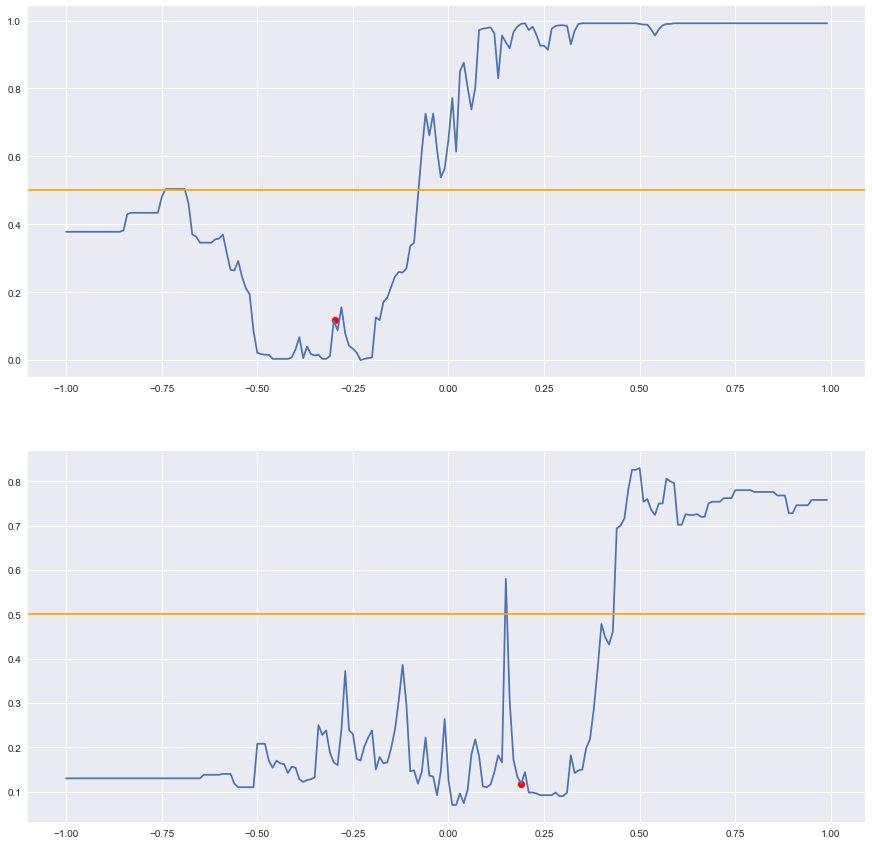

In [9]:
'''
ETUDE PROBA EN FONCTION DES DEPLACEMENTS SUR LES AXES
'''
GOAL = 1 - int(pred(X_test[idx_test])>0.5)

stp = np.zeros(X.shape[1])
print('Xtest[idx]', X_test[idx_test])
print('proba idx', pred(X_test[idx_test]))
n_features = X.shape[1]

f, ax_ = plt.subplots(n_features, 1)
f.set_figheight(15)
f.set_figwidth(15)
for VAR in range(n_features):
    o_ = X_test[idx_test].copy()
    xx = -1.0
    xa, ya = [], []

    for i in range(200):        
        o_[VAR] = xx
        yy = pred(o_)
        xa.append(xx)
        ya.append(yy)
        xx += 0.01
    ax_[VAR].plot(xa, ya)
    ax_[VAR].scatter(X_test[idx_test][VAR], pred(X_test[idx_test]), color='red')
    ax_[VAR].axhline(y=0.5, color='orange')
plt.show()

    


0.741969681713


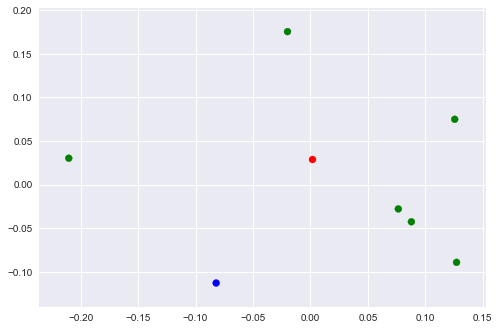

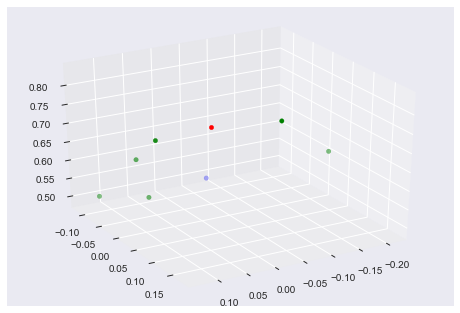

In [630]:
'''
PLOT VOISINS 2D + 3D (avec proba)
'''


from sklearn.metrics.pairwise import pairwise_distances
D = pairwise_distances(X, X[idx].reshape(1, -1), metric='euclidean', n_jobs=-1)
idxes = [x[0] for x in sorted(enumerate(D), key=lambda y:y[1])]
print(pred(X[idx]))
nn = 8
AX1, AX2 = 0 ,1


plt.scatter([X[x][AX1] for x in idxes[1:nn]], [X[x][AX2] for x in idxes[1:nn]], color=[['blue', 'green'][clf.predict(X[x].reshape(1,-1))[0]] for x in idxes[1:nn]])
plt.scatter(X[idx][AX1], X[idx][AX2], color='red')
plt.show()



from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter([X[x][AX1] for x in idxes[1:nn]], 
           [X[x][AX2] for x in idxes[1:nn]], 
           [pred(X[x]) for x in idxes[1:nn]], 
           zdir='z', s=20, depthshade=True, 
           color=[['blue', 'green',][int(i>0.5)] for i in [pred(X[x]) for x in idxes[1:nn]]])
ax.scatter(X[idx,AX1], X[idx, AX2], pred(X[idx]), color='red')
ax.view_init(30, 60)
plt.show()

In [75]:
'''
CLOSEST NEIGHBORS PROBABILITUES
'''
from sklearn.metrics.pairwise import pairwise_distances
D = pairwise_distances(X, X[idx].reshape(1, -1), metric='euclidean', n_jobs=-1)
idxes = [x[0] for x in sorted(enumerate(D), key=lambda y:y[1])]
print(pred(X[idx]))

ennemies_probs = np.array([[X[x], pred(X[x]), D[x]] for x in idxes if not same_class(X[x], X[idx])])
score = (ennemies_probs[:,1] - 0.5) / ennemies_probs[:,2]
score = score.reshape(len(score),1)
ennemies_scored = np.append(ennemies_probs, score, axis=1)
ennemies_scored_s = sorted(ennemies_scored, key=lambda x: x[-1], reverse=True)

#1ere colonne coordonnées observation (ennemis)
#2eme colonne proba pred
#3eme colonne distance à idx
#4eme distance en proba/ distancer en longueur

#triés par score: ce sont les ennemis les plus intéressants 
# (les plus proches avec une proba la plus différente)

0.09


KeyboardInterrupt: 

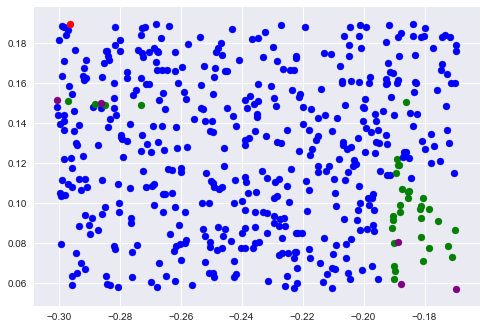

In [16]:
#definissons un carre entre idx et le premier voisin
#on va generer au pif dans ce carre



first_enn = np.array([list(x) for x in np.array(ennemies_scored_s)[:5, 0]])
coords = np.append(first_enn, X[idx].reshape(1, X.shape[1]), axis=0)

#returns a (n_features, 2) vector. For each feature, min and max
def limits_hyper_cube(obs):
    mins = np.min(obs, axis=0)
    maxs = np.max(obs, axis=0)
    return list(zip(mins, maxs))

#a, b, c, d = np.min(coords, axis=0)[0], np.max(coords, axis=0)[0], np.min(coords, axis=0)[1], np.max(coords, axis=0)[1]

from random import random
def generate_hypercube(limits, plot=True):
    n_f = X.shape[1]
    AX1, AX2 = 0,1
    for i in range(500):
        obs = []
        for d in range(n_f):
            a, b = limits[d]
            x = a + (b - a) * random()
            obs.append(x)
        pr = pred(np.array(obs))
        if plot:
             plt.scatter(obs[AX1], obs[AX2], color=['blue', 'green'][int(pr>0.5)])
    if plot:
        plt.scatter(X[idx][AX1], X[idx][AX2], color='red')
        plt.scatter(first_enn[:, AX1], first_enn[:, AX2], color='purple')
        plt.show()

generate_hypercube(limits_hyper_cube(coords))


In [633]:
'''
CARACTERISER OBS DANS LA DENSITE
'''



def is_outlier(obs, q):
    out = False
    for f in range(X.shape[1]):
        val = obs[f]
        limit_10 = np.percentile(X[:, f], q)
        limit_90 = np.percentile(X[:, f], 100 - q)
        if val > limit_90 or val < limit_10:
            out = True
            print('outlier in var', f)
            break
    return out

is_outlier(X[idx], 10)



outlier in var 3


True

0 0 1
1 0.001 9
2 0.002 21


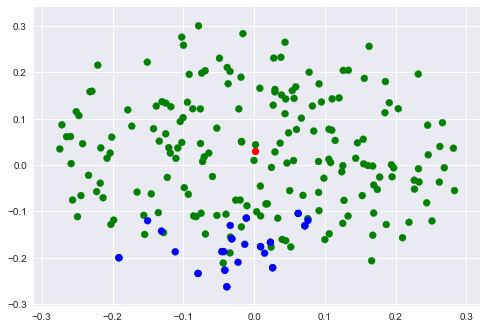

"ennemies = sorted(ennemies, key=lambda x: manhattan_distances(x[:-1], X_test[idx]))\n\nfor border in ennemies:\n    print('In order to join its neighbour, our observation would need:')\n    for v in range(X_test.shape[1]):\n        print('%f in variable %d (value= %f); Range= (%f, %f)' %(border[v] - X_test[idx, v], v, X_test[idx,v], X_test[:, v].min(), X_test[:, v].max()))\n\n"

In [634]:
#idx = np.random.randint(X_test.shape[0])
''' 
FAIRE GRANDIR BOULES
'''
#import random
from numpy import random
from math import pi, cos, sin
#from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.metrics.pairwise import manhattan_distances


AX1, AX2 = 0, 1


def generate_inside_ball(center, d, segment=(0,1)):
    #genere une observation de dimension d dans la "boule" de centre center et de rayon segment
    def norm(v):
        return sum(map(lambda x: x**2, v))**(0.5)
    z = random.normal(0, 1, d)
    z = z/norm(z) * random.uniform(*segment)**(1/float(d))
    z += center
    return z


def generate_inside_manhattan(center, d, segment=(0,1)):
    return 0

def generate_layer_with_pred(center, d, n, segment):
    #generer n observations avec la pred
    out = []
    for i in range(n):
        a = generate_inside_ball(center, d, segment=segment)
        pred = clf.predict(a.reshape(1, -1))
        a = list(a)
        a.append(pred)
        out.append(a)
    return np.array(out)


###GENERE SPHERES A LA SUITE DE PLUS EN PLUS GRANDES; S ARRETE QUAND A TROUVE LE NOMBRE VOULU D ENNEMIS

def seek_ennemies():
    N_LAYER = 200
    STEP=1/1000.0
    ENOUGH_ENNEMIES = 10
    count_ennemies = 0
    ennemies = []
    a0 = 0
    i = 0
    a1 = STEP
    while count_ennemies < ENOUGH_ENNEMIES:
        layer_ = generate_layer_with_pred(X[idx], X.shape[1], n=N_LAYER, segment=(a0, a1))
        count_ennemies += int(abs(int(sum(layer_[:, -1])) - N_LAYER*clf.predict(X[idx].reshape(1,-1))))
        ennemies.extend([x for x in layer_ if x[-1] == 1-clf.predict(X[idx].reshape(1, -1))])
        print(i, a0, count_ennemies)
        i += 1
        a0 += STEP
        a1 += STEP
    return layer_, ennemies

layer_, ennemies = seek_ennemies()


plt.scatter([x[AX1] for x in layer_], [x[AX2] for x in layer_], color=[['blue', 'green'][int(x[-1])] for x in layer_])
plt.scatter([x[AX1] for x in ennemies], [x[AX2] for x in ennemies], color=[['blue', 'green'][int(x[-1])] for x in ennemies])
#plt.scatter([X[x][AX1] for x in idxes[:50]], [X[x][AX2] for x in idxes[:50]], color='purple')
plt.scatter(X[idx, AX1], X[idx, AX2], color='red')
plt.show()


'''ennemies = sorted(ennemies, key=lambda x: manhattan_distances(x[:-1], X_test[idx]))

for border in ennemies:
    print('In order to join its neighbour, our observation would need:')
    for v in range(X_test.shape[1]):
        print('%f in variable %d (value= %f); Range= (%f, %f)' %(border[v] - X_test[idx, v], v, X_test[idx,v], X_test[:, v].min(), X_test[:, v].max()))

'''

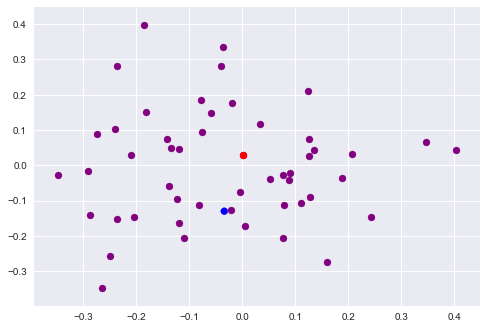

In [635]:

#plt.scatter(first_enn[:, AX1], first_enn[:, AX2], color='purple') #A RECOMPUTER LA HAUT
plt.scatter([X[x][AX1] for x in idxes[:50]], [X[x][AX2] for x in idxes[:50]], color='purple')
plt.scatter(ennemies[0][AX1], ennemies[0][AX2], color=[['blue', 'green'][int(x[-1])] for x in ennemies])
plt.scatter(X[idx, AX1], X[idx, AX2], color='red')
plt.show()

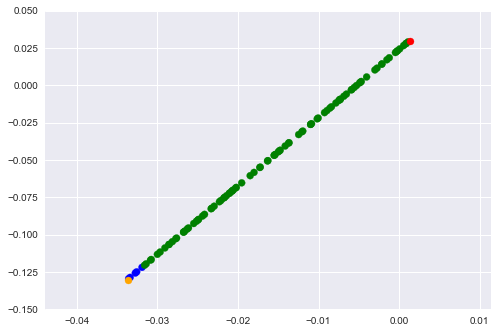

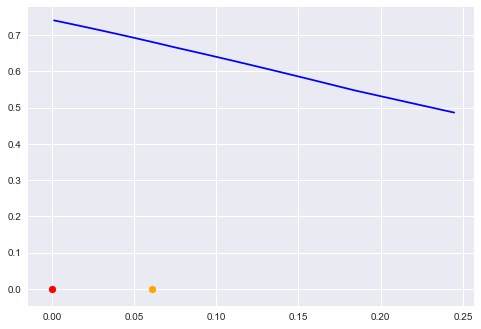

In [638]:
AX1, AX2 = 0, 1
def generate_between(obs1, obs2, n=100):
    news = []
    for i in range(n):
        a = random.random() * 1
        new = a * obs2 + (1 - a)*obs1
        news.append(new)
    return news
genobs = generate_between(X[idx], ennemies[0][:-1])
plt.scatter([x[AX1] for x in genobs], [x[AX2] for x in genobs], color=[['blue', 'green'][int(pred(x)>0.5)] for x in genobs])
plt.scatter(X[idx, AX1], X[idx, AX2], color='red')
plt.scatter(ennemies[0][AX1], ennemies[0][AX2], color='orange')
plt.show()

from sklearn.metrics.pairwise import pairwise_distances
genobs = sorted(genobs, key=lambda x:pairwise_distances(X[idx].reshape(1, -1), x.reshape(1, -1))[0][0])
plt.plot(pairwise_distances(X[idx].reshape(1, -1), genobs, metric='euclidean')[0], [pred(x) for x in genobs], color='blue')
plt.scatter(0, 0, color='red')
plt.scatter(0.06072482, 0, color='orange')
plt.show()



In [336]:
pairwise_distances(ennemies[0][:-1], X[idx])

/home/laugel/Documents/thesis/code/tests/interpretability_comparison_test/local/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/laugel/Documents/thesis/code/tests/interpretability_comparison_test/local/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([[ 0.06072482]])

0 0 62


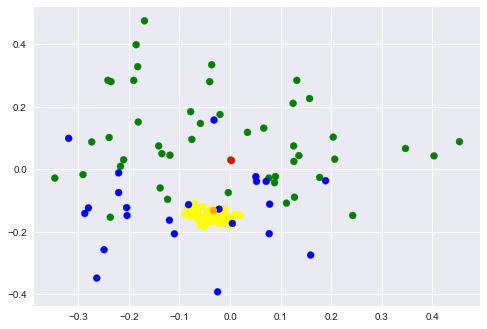

In [640]:
###GENERE SPHERES A LA SUITE DE PLUS EN PLUS GRANDES; S ARRETE QUAND A TROUVE LE NOMBRE VOULU D ENNEMIS
AX1, AX2 = 0, 1
N_LAYER = 100
STEP=1/1000000.0
ENOUGH_ENNEMIES = 10
count_ennemies = 0
ennemies2 = []
a0 = 0
i = 0
a1 = STEP
while count_ennemies < ENOUGH_ENNEMIES:
    layer_ = generate_layer_with_pred(ennemies[0][:-1], X.shape[1], n=N_LAYER, segment=(a0, a1))
    count_ennemies += int(abs(int(sum(layer_[:, -1])) - N_LAYER*clf.predict(X[idx].reshape(1,-1))))
    ennemies2.extend([x for x in layer_ if x[-1] == 1-clf.predict(X[idx].reshape(1, -1))])
    print(i, a0, count_ennemies)
    #plt.scatter([x[AX1] for x in layer_], [x[AX2] for x in layer_], color=[['blue', 'green'][int(x[-1])] for x in layer_])
    i += 1
    a0 += STEP
    a1 += STEP

plt.scatter([x[AX1] for x in ennemies2], [x[AX2] for x in ennemies2], color='yellow')
plt.scatter([X[x][AX1] for x in idxes[:70]], [X[x][AX2] for x in idxes[:70]], color=[['blue', 'green'][int(pred(X[x])>0.5)] for x in idxes])
plt.scatter(ennemies[0][AX1], ennemies[0][AX2], color='orange')
plt.scatter(X[idx, AX1], X[idx, AX2], color='red')
plt.show()


prediction of our red obs 0.741969681713
prediction of first ennemy 0.485417059308
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


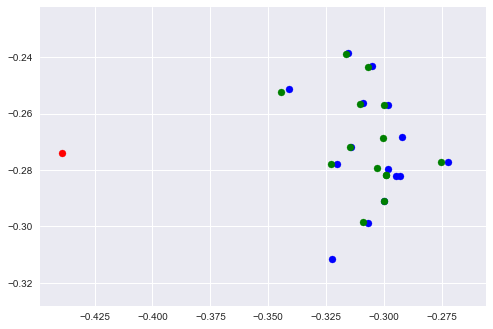

In [641]:
print('prediction of our red obs', pred(X[idx]))
print('prediction of first ennemy', pred(ennemies[0][:-1]))

#ennemies[0] (ou autre) est l ennemi que je vais considérer pour ma poche robuste
# ensuite j'utilise ennemies2 qui contient ses voisins.

'''
TRUE BORDER: les plus pres parmi les plus pres
'''
ennemies2 = ennemies2[:15]

closests_enn, closests_all = [], []
GOAL_ = int(pred(X[idx])> 0.5)
for enn in ennemies2:
    print(len(closests_enn))
    obs_segment = generate_between(enn[:-1], X[idx])
    distances_proba_enn = [(pairwise_distances(X[idx].reshape(1,-1), x.reshape(1,-1))[0], x) for x in obs_segment if int(pred(x.reshape(1,-1))>0.5) != GOAL_]
    distances_proba_all = [(pairwise_distances(X[idx].reshape(1,-1), x.reshape(1,-1))[0], x) for x in obs_segment if int(pred(x.reshape(1,-1))>0.5) == GOAL_]
    try:
        closests_enn.append(sorted(distances_proba_enn, key=lambda x: x[0])[0][1])
        closests_all.append(sorted(distances_proba_all, key=lambda x: x[0])[-1][1])
    except IndexError:
        closests_enn.append(enn[:-1])
closests_enn = np.array(closests_enn)
closests_all = np.array(closests_all)

AX1, AX2 = 3, 2
plt.scatter(closests_enn[:, AX1], closests_enn[:, AX2], color='blue')
plt.scatter(closests_all[:, AX1], closests_all[:, AX2], color='green')
plt.scatter(X[idx, AX1], X[idx, AX2], color='red')
plt.show()

    


real proba observation 0.741969681713
tree acc 0.9
obs predicted [1]
logreg acc 0.6
[(2, 0.018815836283234525), (0, 0.020289292454553354), (4, -0.053917566120178825), (3, -0.077226943525052633), (1, 0.10424035156499745)]


/home/laugel/Documents/thesis/code/tests/interpretability_comparison_test/local/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


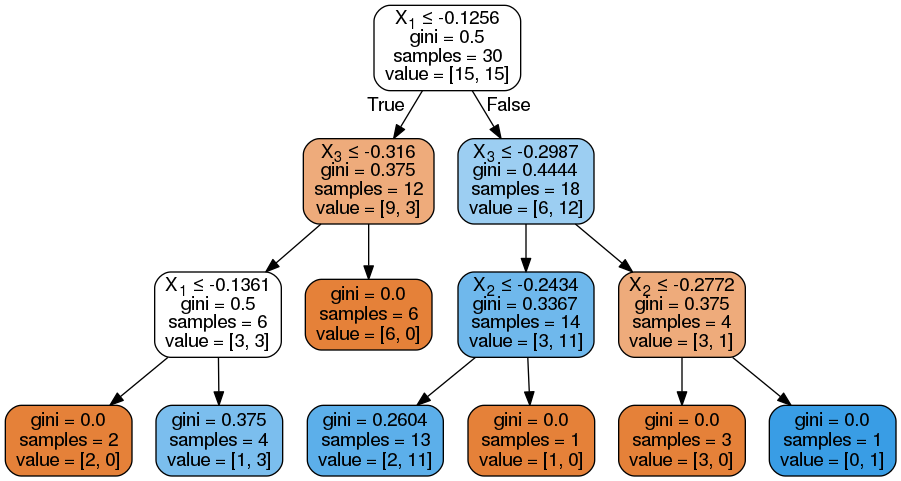

In [645]:
'''
ON VA TRAIN UN ARBRE LOCAL.

'''

#dataset = 
X_border = np.append(closests_enn, closests_all, axis=0)
X_border = np.append(X_border, X[idx].reshape(1, X.shape[1]), axis=0)

y_border = [1 - GOAL_]*closests_enn.shape[0] + [GOAL_] * closests_all.shape[0] + [GOAL_]

print('real proba observation', pred(X[idx]))


#puis arbre
from sklearn import tree, metrics
clf_border = tree.DecisionTreeClassifier(max_depth=3)
clf_border.fit(X_border, y_border)
print('tree acc', metrics.accuracy_score(clf_border.predict(X_border), y_border))
print('obs predicted', clf_border.predict(X[idx]))
'''
probleme actuel: pas assez de data créée ==> les feuilles suffisent
pas à me faire changer car j'ai des trous dans mes data
'''
clf_border2 = LogisticRegression()
clf_border2.fit(X_border, y_border)
print('logreg acc', metrics.accuracy_score(clf_border2.predict(X_border), y_border))
print(sorted(list(enumerate(clf_border2.coef_[0])), key=lambda x: abs(x[1])))


from IPython.display import Image
import pydotplus
dot_data = tree.export_graphviz(clf_border, out_file=None,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())



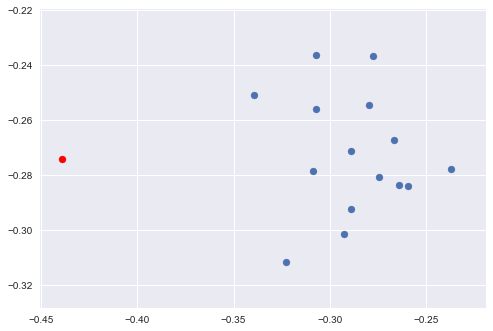

In [657]:
ennemies2



In [ ]:
for f in X.shape[1]:
    ennemies2